In [8]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import os
import calendar
import datetime 
import zipfile
import re
import sklearn.model_selection as sms 
import scipy.stats
import sklearn.preprocessing 
import sklearn.impute
import boto3
import io 
import scipy.optimize as sopt
import warnings
import joblib 
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.metrics as skm
import helpers.haws as haws
import numpy as np
import pandas as pd
import scipy.stats as scps 
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [6]:
# Initialize a session.
s3 = haws.get_service_resource(aws_profile='ck', service_name = 's3')

# Define the S3 bucket and the file location
bucket_name = 'cryptokaizen-data-test'
s3_file_path = 'kaizen_ai/soccer_prediction/model_output/glm_model_predictions.csv'

# Retrieve the CSV file from S3
obj = s3.Object(bucket_name, s3_file_path)
data = obj.get()['Body'].read().decode('utf-8')

# Load the CSV file content into a pandas DataFrame
poisson_df = pd.read_csv(io.StringIO(data))

# Display the first few rows of the DataFrame
print(poisson_df.head())

         Date    Sea   Lge             HT                    AT  HS  AS  \
0  2012-04-28  12-13  CHL1  CD Huachipato  Universidad Catolica   2   2   
1  2014-04-13  13-14  CHL1  CD Huachipato  Universidad de Chile   5   2   
2  2010-02-14  10-11  CHL1  CD Huachipato        Union Espanola   1   2   
3  2010-11-07  10-11  CHL1  CD Huachipato               Higgins   2   1   
4  2014-01-10  13-14  CHL1  CD Huachipato           CSD Rangers   3   2   

   Lambda_HS  Lambda_AS  prob_home_win  prob_away_win  prob_draw  \
0          2          2       0.396453       0.396453   0.207002   
1          2          2       0.396453       0.396453   0.207002   
2          2          2       0.396453       0.396453   0.207002   
3          2          2       0.396453       0.396453   0.207002   
4          1          1       0.345746       0.345746   0.308508   

  predicted_outcome actual_outcome  
0              draw           draw  
1              draw       home_win  
2              draw       awa

### Paired t-test Random classifier-Poisson

In [9]:
# Normalize probabilities to sum to 1
poisson_df['prob_home_win'] /= (poisson_df['prob_home_win'] + poisson_df['prob_away_win'] + poisson_df['prob_draw'])
poisson_df['prob_away_win'] /= (poisson_df['prob_home_win'] + poisson_df['prob_away_win'] + poisson_df['prob_draw'])
poisson_df['prob_draw'] /= (poisson_df['prob_home_win'] + poisson_df['prob_away_win'] + poisson_df['prob_draw'])

# Determine predicted outcomes based on highest probability
poisson_df['predicted_poisson'] = poisson_df[['prob_home_win', 'prob_away_win', 'prob_draw']].idxmax(axis=1)
poisson_df['predicted_poisson'] = poisson_df['predicted_poisson'].apply(lambda x: 'home' 
                                                        if x == 'prob_home_win' 
                                                        else ('away' if x == 'prob_away_win' else 'draw'))

# Generate random predictions for the naive classifier
np.random.seed(42)  # For reproducibility
poisson_df['predicted_random'] = np.random.choice(['home', 'away', 'draw'], size=len(df))

# Define actual outcomes
def get_actual_outcome(row):
    if row['HS'] > row['AS']:
        return 'home'
    elif row['HS'] < row['AS']:
        return 'away'
    else:
        return 'draw'

poisson_df['actual_outcome'] = poisson_df.apply(get_actual_outcome, axis=1)

# Compute accuracy for Poisson model and random classifier
poisson_df['accuracy_poisson'] = (poisson_df['predicted_poisson'] == poisson_df['actual_outcome']).astype(int)
poisson_df['accuracy_random'] = (poisson_df['predicted_random'] == poisson_df['actual_outcome']).astype(int)

# Perform paired t-test
t_stat, p_value = scps.ttest_rel(poisson_df['accuracy_poisson'], poisson_df['accuracy_random'])

# Print results
print(f"Poisson Model Accuracy: {poisson_df['accuracy_poisson'].mean()}")
print(f"Random Classifier Accuracy: {poisson_df['accuracy_random'].mean()}")
print(f"Paired t-test: t-statistic = {t_stat}, p-value = {p_value}")

Poisson Model Accuracy: 0.4699325552279795
Random Classifier Accuracy: 0.3279754452566536
Paired t-test: t-statistic = 32.65216084647199, p-value = 5.3476505383395314e-229


### visualize the value counts of wins/losses/draw

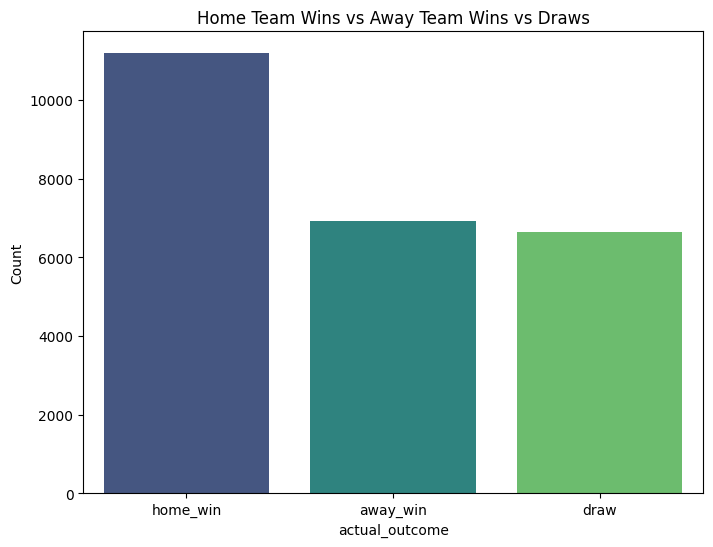

In [12]:
# 1. Instances that home team won vs. away team won vs. draw
win_counts = df['actual_outcome'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=win_counts.index, y=win_counts.values, palette='viridis')
plt.title('Home Team Wins vs Away Team Wins vs Draws')
plt.ylabel('Count')
plt.show()

### Naive - Poisson

In [14]:
# Normalize probabilities to sum to 1
df['prob_home_win'] /= (df['prob_home_win'] + df['prob_away_win'] + df['prob_draw'])
df['prob_away_win'] /= (df['prob_home_win'] + df['prob_away_win'] + df['prob_draw'])
df['prob_draw'] /= (df['prob_home_win'] + df['prob_away_win'] + df['prob_draw'])

# Determine predicted outcomes based on highest probability
df['predicted_poisson'] = df[['prob_home_win', 'prob_away_win', 'prob_draw']].idxmax(axis=1)
df['predicted_poisson'] = df['predicted_poisson'].apply(lambda x: 'home' if x == 'prob_home_win' else ('away' if x == 'prob_away_win' else 'draw'))

# Generate predictions for the naive classifier (always predicting home win)
df['predicted_naive'] = 'home'

# Define actual outcomes
def get_actual_outcome(row):
    if row['HS'] > row['AS']:
        return 'home'
    elif row['HS'] < row['AS']:
        return 'away'
    else:
        return 'draw'

df['actual_outcome'] = df.apply(get_actual_outcome, axis=1)

# Compute accuracy for Poisson model and naive classifier
df['accuracy_poisson'] = (df['predicted_poisson'] == df['actual_outcome']).astype(int)
df['accuracy_naive'] = (df['predicted_naive'] == df['actual_outcome']).astype(int)

# Perform paired t-test
t_stat_poisson_naive, p_value_poisson_naive = scps.ttest_rel(df['accuracy_poisson'], df['accuracy_naive'])

# Print results
print(f"Poisson Model Accuracy: {df['accuracy_poisson'].mean()}")
print(f"Naive Classifier Accuracy: {df['accuracy_naive'].mean()}")
print(f"Paired t-test (Poisson vs. Naive): t-statistic = {t_stat_poisson_naive}, p-value = {p_value_poisson_naive}")

Poisson Model Accuracy: 0.4699325552279795
Naive Classifier Accuracy: 0.4517184281733371
Paired t-test (Poisson vs. Naive): t-statistic = 10.274272859062222, p-value = 1.0318130287358916e-24
